#### Code to analyse the demogrpahic data for pre- and post-implementation for services using the AI-enabled self-referral tool. 
We are using quaterly data as NHS Digital only reports demographic information quaterly

The quaters reported are different to actual yearly quaters, e.g. their Q4 2020/21 is actually Q1 of 2021 

## Prepare and clean data

In [70]:
import requests
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
from datetime import date
import math
from scipy.stats import chi2_contingency 
import datetime
from dateutil.relativedelta import relativedelta as relativedelta
from iteration_utilities import deepflatten
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import io
import sys
from numpy.linalg import norm
import glob

import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy

from scipy.spatial.distance import cityblock


data_folder="/Users/johanna/Documents/GitHub/Limbic-increased-access/Quaterly data"
folder_figures_save='/Users/johanna/Library/CloudStorage/GoogleDrive-johanna@limbic.ai/Shared drives/05_Research/Publications (research papers)/Clinical/Increased_Access/Figures/'



### Combine and clean data

In [71]:
#upload the data and merge
os.chdir(data_folder)
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all csv files
combined_csv = pd.concat([pd.read_csv(f, dtype = {'ProviderName': str}, na_values = '*') for f in all_filenames ]) 

# change 'surrey iapt' to "mind matters surrey nhs" as their name was changed from March 2022
combined_csv.loc[combined_csv["ProviderName"] == 'SURREY IAPT', 'ProviderName'] = 'MIND MATTERS SURREY NHS'

#only include the referral data
data_referrals = combined_csv[combined_csv['MEASURE_NAME'] == 'Count_ReferralsReceived']

#drop the total for all providers
data_referrals = data_referrals[~(data_referrals['Provider'] == 'All_Provider')]

# replace nans for 1 service with the correct service name
data_referrals.loc[data_referrals['Provider'] == 'RTV', 'ProviderName'] = 'NORTH WEST BOROUGHS HEALTHCARE NHS FOUNDATION TRUST'



In [72]:
#define the pre and post quaters for each service

input_data_insight={"service":'insight',
    'pre':'Quarter 2 2021/22', #Q3 2021
    'post':'Quarter 4 2021/22', # Q1 2022
} 

input_data_surrey={"service":'mind matters surrey nhs', #name was changed to "mind matters surrey nhs" from March 2022
    'pre':'Quarter 1 2021/22', #Q2 2021
    'post':'Quarter 3 2021/22', #Q4 2021
} #  went live 26th July 2021 

input_data_trent={"service":'trent',
    'pre':'Quarter 1 2021/22', #Q2 2021
    'post':'Quarter 3 2021/22', #Q4 2021
}  #trent went live 6th July 2021


input_data_vita={"service":'vita health',
    'pre':'Quarter 3 2020/21', #Q4 2020
    'post':'Quarter 4 2020/21', #Q1 2021
} 

inputs_services_tool=[input_data_insight, input_data_trent, input_data_vita, input_data_surrey]

In [73]:
#function to get data for one service on certain demographics
def get_data_for_each_service(data_all, inputs_services, demographics):

    service_ind = []
    service = inputs_services['service']

    for k in data_all['ProviderName']: #tag the provider
        if k.lower().startswith(service.lower()):
            service_ind.append(True)
        else: 
            service_ind.append(False)
    data_all['service_index']=np.array(service_ind)
    data_provider=data_all[data_all['service_index']==True]

    pre_quater = inputs_services['pre'] #pre timeline
    post_quater = inputs_services['post'] #post timeline

    pre_period = data_provider[data_provider['Quarter'] == pre_quater] #just include pre data
    post_period = data_provider[data_provider['Quarter'] == post_quater] #just include post data

    pre_measure = pre_period[pre_period['VariableType'] == demographics] #take pre period for the specific demographics
    post_measure = post_period[post_period['VariableType'] == demographics]

    new_pre_table = pre_measure[['ProviderName','VariableA','VariableB','MEASURE_VALUE_SUPPRESSED']]
    new_pre_table = new_pre_table.rename(columns={"MEASURE_VALUE_SUPPRESSED": "PreTotalReferrals"})
    new_pre_table['Provider'] = service

    new_post_table = post_measure[['ProviderName','VariableA','VariableB','MEASURE_VALUE_SUPPRESSED']]
    new_post_table = new_post_table.rename(columns={"MEASURE_VALUE_SUPPRESSED": "PostTotalReferrals"})
    new_post_table['Provider'] = service

    service_data = new_pre_table.merge(new_post_table)
    
    return service_data

## Find referrals for certain demographics for the services using the IA-enabled self-referral tool

Have to change the demographics variable to find numbers for each different demographics!

In [103]:
#This needs to be changed depending on what you want to look at
demographics = 'Sexual Orientation' # 'Ethnic Group'  'Gender' 'Sexual Orientation'


In [104]:
#create empty datadrame
appended_data = pd.DataFrame(columns = ['ProviderName','VariableA','VariableB','PreTotalReferrals','PostTotalReferrals'])

#fill the dataframe for all services
for i, input_data in enumerate(inputs_services_tool):

    output = get_data_for_each_service(data_referrals, input_data, demographics) #dataframe for one service
    appended_data = pd.concat([appended_data, output])
    

In [105]:
pre_tool_demo_all = []
post_tool_demo_all = []
demographic_all = []
pre_post_diff_all = []

for i in range(0,len(appended_data['VariableA'].unique())):
    
    demographic = sorted(appended_data['VariableA'].unique())[i]
    
    pre_tool_total = np.sum(appended_data[appended_data['VariableA'] == sorted(appended_data['VariableA'].unique())[i]]['PreTotalReferrals'])
    
    post_tool_total = np.sum(appended_data[appended_data['VariableA'] == sorted(appended_data['VariableA'].unique())[i]]['PostTotalReferrals'])
    
    tool_pre_post_diff = post_tool_total - pre_tool_total
            
    pre_tool_demo_all.append(pre_tool_total)
    post_tool_demo_all.append(post_tool_total)
    demographic_all.append(demographic)
    pre_post_diff_all.append(tool_pre_post_diff)
    
tool_demo_all = {'demographic': demographic_all,
                'pre_tool': pre_tool_demo_all,
                'post_tool': post_tool_demo_all,
                'pre_post_diff_tool' : pre_post_diff_all} 


## Plots

### Plot percentage change for gender for Figure 3 and run the stats

NB! Ensure you have chnaged the demographics variable to 'Gender' above

In [97]:
for i in range(0,len(tool_demo_all['demographic'])):

    print(tool_demo_all['demographic'][i], (tool_demo_all['pre_post_diff_tool'][i]/tool_demo_all['pre_tool'][i])*100)

Female 18.25415963346998
Indeterminate (unable to be classified as either male or female) 235.0
Male 15.601023017902813
Not stated/Not known/Invalid 0.0


In [98]:
# add the aeroport font for the plots
import matplotlib.font_manager as fm

font_path = '/Users/johanna/Downloads/Aeroport.ttf'  # the location of the font file
my_font = fm.FontProperties(fname=font_path)  # get the font based on the font_path

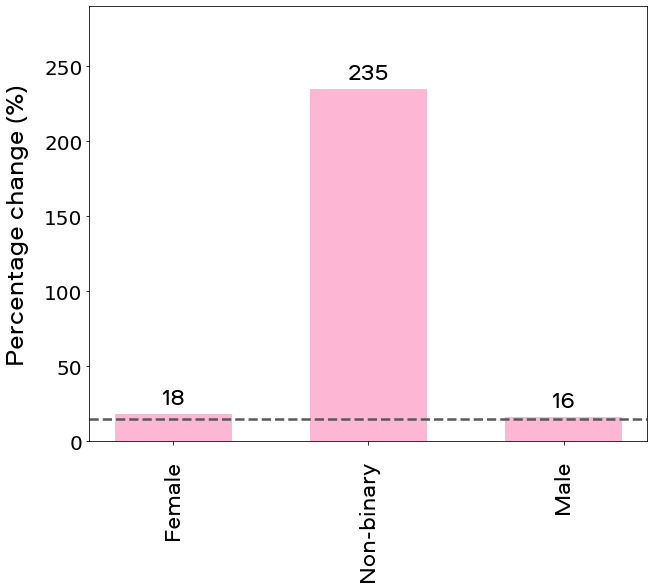

In [99]:
fig, ax = plt.subplots(figsize=(10, 8))

change_lim=[]
category=[]
for p in range(len(tool_demo_all['demographic'])): 
    if tool_demo_all['demographic'][p]!='Not stated/Not known/Invalid':
        change_lim.append(((np.array(tool_demo_all['pre_post_diff_tool'])[[p]].sum()/np.array(tool_demo_all['pre_tool'])[[p]].sum()))*100)
        category.append(tool_demo_all['demographic'][p])

x=[z for z in range(len(change_lim))]

pl = plt.bar(x, [round(num) for num in change_lim], color = '#fdb6d3', width = 0.6)

ax.set_xticks(x, ['Female', 'Non-binary', 'Male'], fontsize=23, rotation=90, font = my_font)
ax.set_ylabel('Percentage change (%)', fontsize=26,font = my_font, labelpad=15)


ax.bar_label(pl,fontsize=24, font = my_font, padding = 5)


ax.tick_params(axis='x', which='major', pad=15)

plt.yticks(fontsize=20)

plt.ylim(0,290)

plt.axhline(15, color= '#595959', ls='--', linewidth = 2.5)


image_format = 'png' # e.g .png, .svg, etc.
image_name = folder_figures_save+'gender_referrals.png'

# fig.savefig(image_name, format=image_format, bbox_inches="tight", dpi=1200)


In [100]:
# Change data to single-patient level

change_variable=[]
category=[]
cat_order=['Female',
'Indeterminate (unable to be classified as either male or female)',
'Male',
'Not stated/Not known/Invalid'
]

for i in range(len(cat_order)): 
    p=cat_order[i]
    a=np.array(tool_demo_all['demographic'])

    ind=np.where(a==p)[0][0]
    if tool_demo_all['demographic'][ind]!='Not stated/Not known/Invalid':
        change_variable.append(np.array([0]*int(tool_demo_all['pre_tool'][ind]))) #pre tool 0 
        change_variable.append(np.array([1]*int(tool_demo_all['post_tool'][ind]))) # post tool 1 

        category.append(np.array([i]*int(tool_demo_all['pre_tool'][ind]+tool_demo_all['post_tool'][ind])))

change_variable=np.array(list(deepflatten(change_variable)))
category=np.array(list(deepflatten(category)))

data=pd.DataFrame({'DV':change_variable, 'demographic':category})


In [101]:
# run the logistic regression
log_reg = smf.logit("DV ~ C(demographic,Treatment(2))", data=data).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.688943
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     DV   No. Observations:                66765
Model:                          Logit   Df Residuals:                    66762
Method:                           MLE   Df Model:                            2
Date:                Fri, 12 May 2023   Pseudo R-squ.:                0.001089
Time:                        16:39:11   Log-Likelihood:                -45997.
converged:                       True   LL-Null:                       -46047.
Covariance Type:            nonrobust   LLR p-value:                 1.648e-22
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.1450      0.014     10.496      0.000       0.118       0.172
C(demographic, Treatment(2))[T.0]     0.0227      0.017      1.357      0.175      -0.010       0.055
C(demographic, Treatment(2))[T.1]     1.0640      0.115      9.269      0.000       0.839       1.289
=====================================================================================================
"""

In [102]:
# Convert to odds ratios
odds_ratios = pd.DataFrame(
    {"OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1]}
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)

                                         OR  Lower CI  Upper CI
Intercept                          1.156010  1.125134  1.187734
C(demographic, Treatment(2))[T.0]  1.022951  0.989957  1.057044
C(demographic, Treatment(2))[T.1]  2.897898  2.314072  3.629020


### Plot percentage change for sexuality for Figure 3 and run the stats
NB! Ensure you have chnaged the demographics variable to 'Sexual Orientation' above

In [109]:
for i in range(0,len(tool_demo_all['demographic'])):

    print(tool_demo_all['demographic'][i], (tool_demo_all['pre_post_diff_tool'][i]/tool_demo_all['pre_tool'][i])*100)

Bi-sexual 30.16304347826087
Gay/Lesbian 19.101123595505616
Heterosexual 13.74185667752443
Not stated/Not known/Invalid 38.78865979381443


In [110]:
# add the aeroport font for the plots
import matplotlib.font_manager as fm

font_path = '/Users/johanna/Downloads/Aeroport.ttf'  # the location of the font file
my_font = fm.FontProperties(fname=font_path)  # get the font based on the font_path

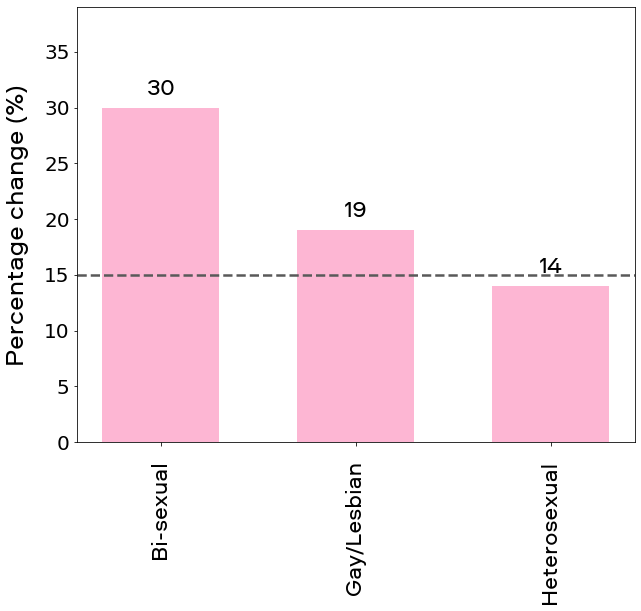

In [111]:
fig, ax = plt.subplots(figsize=(10, 8))

change_lim=[]
category=[]
for p in range(len(tool_demo_all['demographic'])): 
    if tool_demo_all['demographic'][p]!='Not stated/Not known/Invalid':
        change_lim.append(((np.array(tool_demo_all['pre_post_diff_tool'])[[p]].sum()/np.array(tool_demo_all['pre_tool'])[[p]].sum()))*100)
        category.append(tool_demo_all['demographic'][p])

x=[z for z in range(len(change_lim))]

pl = ax.bar(x, [round(num) for num in change_lim], color = '#fdb6d3', width = 0.6)

plt.axhline(15, color= '#595959', ls='--', linewidth = 2.5)

ax.set_ylabel('Percentage change (%)', fontsize=26,font = my_font, labelpad=15)

ax.set_xticks(x, category, fontsize=23, rotation=90, font = my_font)
ax.bar_label(pl,fontsize=24, font = my_font, padding = 8)

ax.tick_params(axis='x', which='major', pad=15)

plt.ylim(0,39)

plt.yticks(fontsize=20)


image_format = 'png' # e.g .png, .svg, etc.
image_name = folder_figures_save+'sexuality_referrals.png'


# fig.savefig(image_name, format=image_format, bbox_inches="tight", dpi=1200)


In [112]:
# Change data to single-patient level

change_variable=[]
category=[]
cat_order=['Heterosexual',
'Bi-sexual',
'Gay/Lesbian',
'Not stated/Not known/Invalid'
]

for i in range(len(cat_order)): 
    p=cat_order[i]
    a=np.array(tool_demo_all['demographic'])

    ind=np.where(a==p)[0][0]
    if tool_demo_all['demographic'][ind]!='Not stated/Not known/Invalid':
        change_variable.append(np.array([0]*int(tool_demo_all['pre_tool'][ind]))) #pre tool 0 
        change_variable.append(np.array([1]*int(tool_demo_all['post_tool'][ind]))) # post tool 1 

        category.append(np.array([i]*int(tool_demo_all['pre_tool'][ind]+tool_demo_all['post_tool'][ind])))

change_variable=np.array(list(deepflatten(change_variable)))
category=np.array(list(deepflatten(category)))

data=pd.DataFrame({'DV':change_variable, 'demographic':category})


In [113]:
# Run the regression
log_reg = smf.logit("DV ~ C(demographic,Treatment(0))", data=data).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.690569
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     DV   No. Observations:                57705
Model:                          Logit   Df Residuals:                    57702
Method:                           MLE   Df Model:                            2
Date:                Fri, 12 May 2023   Pseudo R-squ.:               0.0002247
Time:                        16:39:28   Log-Likelihood:                -39849.
converged:                       True   LL-Null:                       -39858.
Covariance Type:            nonrobust   LLR p-value:                 0.0001287
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.1288      0.009     14.720      0.000       0.112       0.146
C(demographic, Treatment(0))[T.1]     0.1349      0.032      4.187      0.000       0.072       0.198
C(demographic, Treatment(0))[T.2]     0.0460      0.065      0.710      0.478      -0.081       0.173
=====================================================================================================
"""

In [114]:
# Convert to odds ratios
odds_ratios = pd.DataFrame(
    {"OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1]}
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)

                                         OR  Lower CI  Upper CI
Intercept                          1.137419  1.118085  1.157087
C(demographic, Treatment(0))[T.1]  1.144372  1.074359  1.218948
C(demographic, Treatment(0))[T.2]  1.047118  0.922067  1.189128


### Plot percentage change for gender for Figure 3 and run the stats

NB! Ensure you have chnaged the demographics variable to 'Ethnic Group' above

In [80]:
#Add all minorities together for Figure 3C

ethnic_groups_lim = pd.DataFrame(tool_demo_all)
ethnic_groups_nhs = pd.DataFrame(nhs_demo_all)

ethnic_groups = ethnic_groups_lim.merge(ethnic_groups_nhs)

# add all miorities together
all_other_ethnic = ethnic_groups[~ethnic_groups['demographic'] .isin(['Not stated/Not known/Invalid', 'White'])]
ethnic_groups.loc[6]= all_other_ethnic.sum()


In [81]:
df = ethnic_groups[ethnic_groups['demographic'].isin(['White', 'Asian or Asian BritishBlack or Black BritishMixedOther Ethnic Groups','Not stated/Not known/Invalid'])]
df = df.set_index('demographic')

In [82]:
# add the aeroport font for the plots
import matplotlib.font_manager as fm

font_path = '/Users/johanna/Downloads/Aeroport.ttf'  # the location of the font file
my_font = fm.FontProperties(fname=font_path)  # get the font based on the font_path

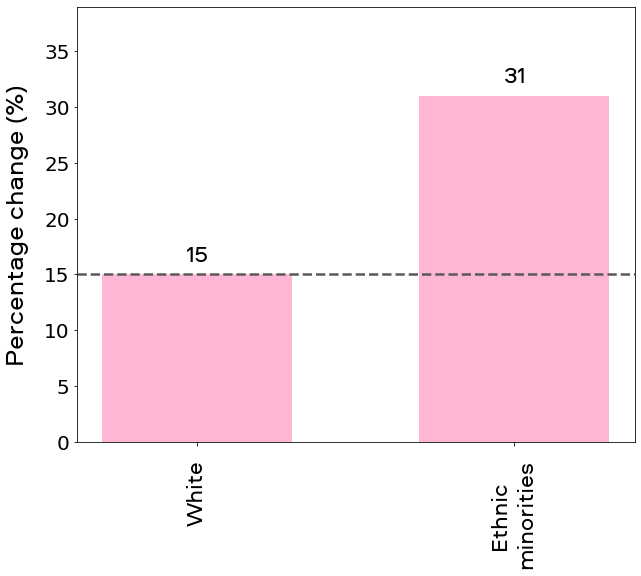

In [83]:
fig, ax = plt.subplots(figsize=(10, 8))

change_lim=[]
category=[]
for p in range(len(df.index.values)): 
    if df.index.values[p]!='Not stated/Not known/Invalid':
        change_lim.append(((np.array(df['post_tool'])[[p]].sum()/np.array(df['pre_tool'])[[p]].sum())-1)*100)
        category.append(df.index.values[p])

x=[z for z in range(len(change_lim))]

pl = plt.bar(x, [round(num) for num in change_lim], color = '#fdb6d3', width = 0.6)

ax.set_xticks(x, ['White', 'Ethnic \nminorities'], fontsize=23, rotation=90, font = my_font)
ax.set_ylabel('Percentage change (%)', fontsize=26, font = my_font, labelpad=15)


ax.bar_label(pl,fontsize=24, font = my_font, padding = 8)

ax.tick_params(axis='x', which='major', pad=15)

plt.yticks(fontsize=20)

plt.ylim(0,39)

plt.axhline(15, color= '#595959', ls='--', linewidth = 2.5)

image_format = 'png' # e.g .png, .svg, etc.
image_name = folder_figures_save+'ethnic_group_referrals.png'

# fig.savefig(image_name, format=image_format, bbox_inches="tight", dpi=1200)


In [84]:
# Change data to single-patient level

from iteration_utilities import deepflatten

change_variable=[]
category=[]
cat_order=['White',
     'Asian or Asian BritishBlack or Black BritishMixedOther Ethnic Groups',
'Not stated/Not known/Invalid']

for i in range(len(cat_order)): 
    p=cat_order[i]
    a=np.array(df.index.values)

    ind=np.where(a==p)[0][0]
    if df.index.values[ind]!='Not stated/Not known/Invalid':
        change_variable.append(np.array([0]*int(df['pre_tool'][ind]))) #pre tool 0 
        change_variable.append(np.array([1]*int(df['post_tool'][ind]))) # post tool 1 

        category.append(np.array([i]*int(df['pre_tool'][ind]+df['post_tool'][ind])))

change_variable=np.array(list(deepflatten(change_variable)))
category=np.array(list(deepflatten(category)))

data=pd.DataFrame({'DV':change_variable, 'demographic':category})

In [85]:
# Run the regression

log_reg = smf.logit("DV ~ C(demographic,Treatment(0))", data=data).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.690184
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     DV   No. Observations:                62430
Model:                          Logit   Df Residuals:                    62428
Method:                           MLE   Df Model:                            1
Date:                Fri, 12 May 2023   Pseudo R-squ.:               0.0002712
Time:                        16:38:57   Log-Likelihood:                -43088.
converged:                       True   LL-Null:                       -43100.
Covariance Type:            nonrobust   LLR p-value:                 1.333e-06
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.1365      0.008     16.151      0.000       0.120       0.153
C(demographic, Treatment(0))[T.1]     0.1308      0.027      4.825      0.000       0.078       0.184
=====================================================================================================
"""

In [86]:
# Convert to odds ratios

odds_ratios = pd.DataFrame(
    {"OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1]}
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)

                                         OR  Lower CI  Upper CI
Intercept                          1.146207  1.127382  1.165346
C(demographic, Treatment(0))[T.1]  1.139752  1.080767  1.201956


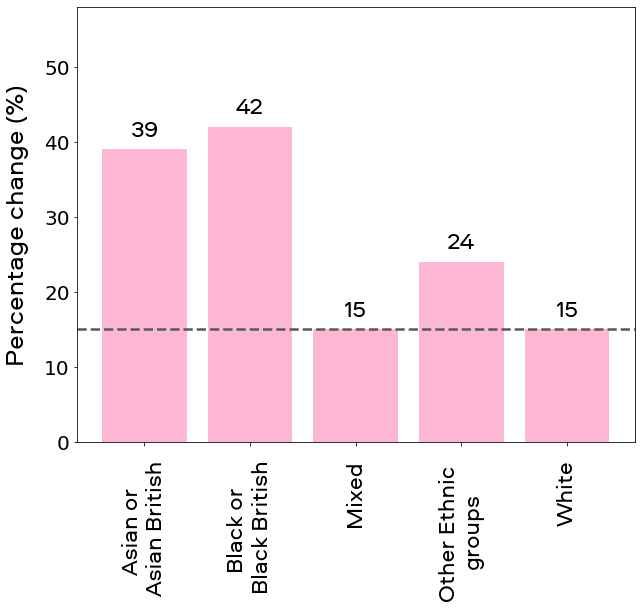

In [87]:
# Plot  Figure 3D

fig, ax = plt.subplots(figsize=(10, 8))

change_lim=[]
category=[]
for p in range(len(tool_demo_all['demographic'])): 
    if tool_demo_all['demographic'][p]!='Not stated/Not known/Invalid':
        change_lim.append(((np.array(tool_demo_all['post_tool'])[[p]].sum()/np.array(tool_demo_all['pre_tool'])[[p]].sum())-1)*100)
        category.append(tool_demo_all['demographic'][p])

x=[z for z in range(len(change_lim))]

pl = plt.bar(x, [round(num) for num in change_lim], color = '#fdb6d3')


ax.set_xticks(x, ['Asian or \nAsian British', 'Black or \nBlack British', 'Mixed', 'Other Ethnic \ngroups', 'White'], fontsize=23, rotation=90, font = my_font)
ax.set_ylabel('Percentage change (%)', fontsize=26, font = my_font, labelpad=15)

ax.bar_label(pl,fontsize=24, font = my_font, padding = 8)

ax.tick_params(axis='x', which='major', pad=15)

plt.yticks(fontsize=20)

plt.ylim(0,58)

plt.axhline(15, color= '#595959', ls='--', linewidth = 2.5)


image_format = 'png' # e.g .png, .svg, etc.
image_name = folder_figures_save+'ethnic_group_separated_referrals.png'

# fig.savefig(image_name, format=image_format, bbox_inches="tight", dpi=1200)



In [88]:
# Change data to single-patient level
change_variable=[]
category=[]
cat_order=['White',
           'Black or Black British',
           'Other Ethnic Groups',
           'Mixed',
           'Asian or Asian British',
           'Not stated/Not known/Invalid'
]

for i in range(len(cat_order)): 
    p=cat_order[i]
    a=np.array(tool_demo_all['demographic'])

    ind=np.where(a==p)[0][0]
    if tool_demo_all['demographic'][ind]!='Not stated/Not known/Invalid':
        change_variable.append(np.array([0]*int(tool_demo_all['pre_tool'][ind]))) #pre tool 0 
        change_variable.append(np.array([1]*int(tool_demo_all['post_tool'][ind]))) # post tool 1 

        category.append(np.array([i]*int(tool_demo_all['pre_tool'][ind]+tool_demo_all['post_tool'][ind])))

change_variable=np.array(list(deepflatten(change_variable)))
category=np.array(list(deepflatten(category)))

data=pd.DataFrame({'DV':change_variable, 'demographic':category})

In [89]:
# Run the regression

log_reg = smf.logit("DV ~ C(demographic,Treatment(0))", data=data).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.690090
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     DV   No. Observations:                62430
Model:                          Logit   Df Residuals:                    62425
Method:                           MLE   Df Model:                            4
Date:                Fri, 12 May 2023   Pseudo R-squ.:               0.0004066
Time:                        16:39:01   Log-Likelihood:                -43082.
converged:                       True   LL-Null:                       -43100.
Covariance Type:            nonrobust   LLR p-value:                 4.548e-07
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.1365      0.008     16.151      0.000       0.120       0.153
C(demographic, Treatment(0))[T.1]     0.2113      0.056      3.801      0.000       0.102       0.320
C(demographic, Treatment(0))[T.2]     0.0749      0.085      0.884      0.377      -0.091       0.241
C(demographic, Treatment(0))[T.3]     0.0074      0.048      0.155      0.877      -0.086       0.101
C(demographic, Treatment(0))[T.4]     0.1928      0.042      4.557      0.000       0.110       0.276
=====================================================================================================
"""

In [90]:
# Convert to odds ratios
odds_ratios = pd.DataFrame(
    {"OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1]}
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)

                                         OR  Lower CI  Upper CI
Intercept                          1.146207  1.127382  1.165346
C(demographic, Treatment(0))[T.1]  1.235318  1.107777  1.377542
C(demographic, Treatment(0))[T.2]  1.077724  0.912943  1.272247
C(demographic, Treatment(0))[T.3]  1.007464  0.917215  1.106592
C(demographic, Treatment(0))[T.4]  1.212696  1.116171  1.317568
